# EDA Notebook

In [1]:
import pandas as pd
import numpy as np
import json
import math
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.neural_network
from sklearn.tree import DecisionTreeClassifier
from collections import defaultdict

In [2]:
analysis_df = pd.read_csv("../data/test/all/metadata/all_audio_features.csv")

# Convert string-based col to list-based col where applicable
analysis_df["genre(s)"] = analysis_df["genre(s)"].str.split('//')
analysis_df["artist_names"] = analysis_df["artist_names"].str.split('//')

In [3]:
analysis_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,analysis_url,duration_ms,time_signature,genre(s),artist_ids,artist_names,name
0,0.529,0.722,1,-4.815,0,0.0814,0.2130,0.000000,0.1020,0.666,79.951,14xRAc1zbSZZzKaYgkwqdY,https://api.spotify.com/v1/audio-analysis/14xR...,212132,4,[kpop],3cjEqqelV9zb4BYE3qDQ4O,[EXO],PLAYBOY
1,0.533,0.838,0,-3.722,1,0.0319,0.1030,0.000000,0.3940,0.451,75.013,7rLvsAO1yb7ElxPhkz60qh,https://api.spotify.com/v1/audio-analysis/7rLv...,196549,4,[kpop],0UEP2XBR9aC5NBKcAKnBIq//4ufh0WuMZh6y4Dmdnklvdl...,"[CHEN, BAEKHYUN, XIUMIN]",For You
2,0.749,0.850,0,-4.346,1,0.0468,0.0319,0.000048,0.0678,0.672,145.983,5EzitieoPnjyKHAq0gfRMa,https://api.spotify.com/v1/audio-analysis/5Ezi...,190423,4,[kpop],3cjEqqelV9zb4BYE3qDQ4O,[EXO],Ko Ko Bop
3,0.619,0.462,4,-9.154,1,0.0402,0.8540,0.000004,0.0932,0.131,123.945,1RMUSljuiZKUNaf6xskK9n,https://api.spotify.com/v1/audio-analysis/1RMU...,193931,4,[kpop],4ufh0WuMZh6y4Dmdnklvdl,[BAEKHYUN],My Love
4,0.629,0.575,6,-5.763,0,0.0354,0.2350,0.000000,0.0935,0.239,136.053,5pesNiBKAx8JNwK2mQ2HEc,https://api.spotify.com/v1/audio-analysis/5pes...,218090,4,[kpop],3cjEqqelV9zb4BYE3qDQ4O,[EXO],지나갈 테니 Been Through


In [4]:
def score_preds(preds, y_test):
    scores = [dict() for _ in preds]
    elem_len = len(preds[0])
    
    for i in range(len(preds)):
        correct = 0
        wrong = 0
        for j in range(len(preds[i])):
            if preds[i, j] == y_test[i, j]:
                correct += 1
            else:
                wrong += 1
        scores[i] = {
            "correct":correct,
            "wrong":wrong,
            "total_elems":elem_len
        }
        
    return pd.DataFrame(scores)

In [67]:
def get_pred_stats(preds, y_test, classes):
    scores_df = score_preds(preds, y_test)
    category_count = scores_df["total_elems"].iloc[0]
    total_correctness = np.mean(scores_df["correct"]/category_count)
    
    preds_df = pd.DataFrame(preds, columns=classes)
    y_test_df = pd.DataFrame(y_test, columns=classes)
    equality_df = preds_df == y_test_df
    
    out = {"correct_predictions":total_correctness}
    
    for genre in equality_df:
        out["{}_error_rate".format(genre)] = 1 - np.mean(equality_df[genre])
    
    return pd.Series(out).round(3).sort_values(ascending=False)

In [6]:
numerical_feats = ['danceability','energy','loudness','key','mode',
                   'speechiness','acousticness','instrumentalness',
                   'liveness','valence','tempo', 'duration_ms',
                   'time_signature']

In [68]:
binarizer = MultiLabelBinarizer()
binarized_data = binarizer.fit_transform(analysis_df["genre(s)"])

X_train, X_test, y_train, y_test = train_test_split(analysis_df[numerical_feats], binarized_data)

models = {#"KNeighborsClassifier":KNeighborsClassifier(),
#           "DecisionTreeClassifier":DecisionTreeClassifier(),
          "RandomForestClassifier":RandomForestClassifier()}#,
#           "MLPClassifier":sklearn.neural_network.MLPClassifier(max_iter=5000)}

for modl_name in models:
    model = models[modl_name]
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(modl_name)
    display(get_pred_stats(preds, y_test, binarizer.classes_))

RandomForestClassifier


correct_predictions     0.928
pop_error_rate          0.123
rock_error_rate         0.087
country_error_rate      0.087
edm_dance_error_rate    0.081
hiphop_error_rate       0.078
jazz_error_rate         0.073
rnb_error_rate          0.054
kpop_error_rate         0.054
reggae_error_rate       0.047
classical_error_rate    0.033
dtype: float64

Text(0, 0.5, 'log proportion')

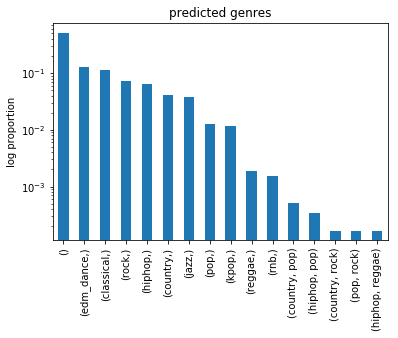

In [69]:
ax = (pd.Series(binarizer.inverse_transform(preds)).value_counts()/len(preds)).plot(kind="bar",
                                                                                    title="predicted genres",
                                                                                    logy=True)
ax.set_ylabel("log proportion")

In [70]:
train_proportion = 0.6

shuffled_data = analysis_df.sample(frac=1, random_state=1)

# no kpop in training set
nokpop_data = shuffled_data[list(map(lambda row:"kpop" not in row, shuffled_data["genre(s)"]))]
X_train_nkpop = nokpop_data[numerical_feats]
y_train_nkpop = binarizer.transform(nokpop_data["genre(s)"])

# kpop with multilabel in test set
kpop_data = shuffled_data[list(map(lambda row:"kpop" in row, shuffled_data["genre(s)"]))]
X_test_kpop = kpop_data[numerical_feats]
y_test_kpop = binarizer.transform(kpop_data["genre(s)"])

models = {"RandomForestClassifier":RandomForestClassifier()}

for modl_name in models:
    model = models[modl_name]
    model.fit(X_train_nkpop, y_train_nkpop)
    preds = model.predict(X_test_kpop)
    print(modl_name)
    display(get_pred_stats(preds, y_test_kpop, binarizer.classes_))

RandomForestClassifier


kpop_error_rate         1.000
correct_predictions     0.874
pop_error_rate          0.090
hiphop_error_rate       0.063
country_error_rate      0.048
edm_dance_error_rate    0.031
rock_error_rate         0.009
jazz_error_rate         0.008
classical_error_rate    0.006
rnb_error_rate          0.000
reggae_error_rate       0.000
dtype: float64

Text(0, 0.5, 'log proportion')

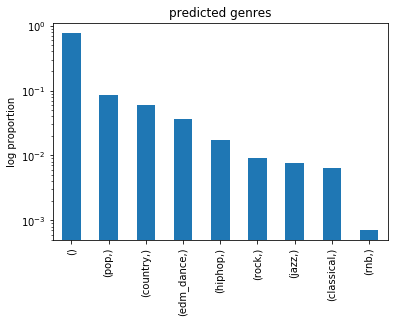

In [64]:
ax = (pd.Series(binarizer.inverse_transform(preds)).value_counts()/len(preds)).plot(kind="bar",
                                                                                    title="predicted genres",
                                                                                    logy=True)
ax.set_ylabel("log proportion")